In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Defining the dataset and the lables we've assigned to each sample.
data = np.zeros((150,10))

#Label 1
data[0] = [1,1,1,1,1,1,1,1,1,1]
for i in range(49):
  data[1+i] = np.random.randint(2, 10, size=10)

#label 0
data[50] = [-1,1,1,1,1,1,1,1,1,1]
for i in range(49):
  data[51+i] = np.random.randint(2, 10, size=10)
  data[51+i][0] = np.random.randint(-10,-2)

#label -1
data[100] = [0,-1,1,1,1,1,1,1,1,1]
for i in range(49):
  data[101+i] = np.random.randint(2, 10, size=10)
  data[101+i][0] = 0
  data[101+i][1] = np.random.randint(-10,-2)

labels = np.zeros((150,3))
labels[:50, 0] = 1
labels[:50, 1] = 0
labels[:50, 2] = 0

labels[50:100, 0] = 0
labels[50:100, 1] = 1
labels[50:100, 2] = 0

labels[100:, 0] = 0
labels[100:, 1] = 0
labels[100:, 2] = 1

In [0]:
# N = Number of training samples, D = Sample dimension.
# data is a N*D matrix of the input dataset.
# lables is a N*1 vector of the true classification labels.
# W_arr is an array of weights matrices, in the order of computation.
# W is the product of all matrices in W_arr.
# W_norms_arr is an array of tensors representing the norms of the weight matrices.
# learning_rate = GD step size.
# n_iter = Number of optimization iterations.
def TrainNN(data, labels, W_arr, W, W_norms_arr, learning_rate, n_iter):
  # X is the placeholder for the input dataset.
  X = tf.placeholder(tf.float64, shape=data.shape)
  # Y is the placeholder for the true classification values. The values are represented as a one-hot vector for each sample.
  Y = tf.placeholder(tf.float64, shape=labels.shape)
  
  W_norm = tf.norm(W)
  
  # Below, we define the structure and computation of the NN using the placeholders,
  # during the optimization process the placeholders are assigned values (defined below as feed_data).
  
  # V is the computed output of the NN. Its length is the number of training samples.
  # When the NN has several layers, V holds the values of the intermediate steps.
  V = tf.matmul(W_arr[0], X) # V is the product of the input data and the weights of the first layer. Do we want to apply the normalization on the input data also??
    
  if len(W_arr) >= 2:
    for i in range(len(W_arr)):
      if i==0: # The first product was already computed above.
        continue
      # Computing the result of the current layer, that is:
      # V_i = W_i * V_i-1
      V = tf.matmul(W_arr[i], V, transpose_a=True)
  
  cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=tf.transpose(V))
  loss = tf.reduce_mean(cross_entropy)
  
  # Defining the gradient descent optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  train = optimizer.minimize(loss)

  # Initializing the tensorflow session.
  sess = tf.Session()
  init = tf.global_variables_initializer()
  sess.run(init)

  # This object places both the input dataset and the true labels on the placeholders.
  feed_data = {X: data, Y: labels}

  # Placeholders for results
  result_loss = []
  result_norm = []
  result_vectors = []
  result_W_norms_arr = np.zeros((len(W_norms_arr), n_iter))
  V_vector = []

  # Run n_iter steps of Gradient Descent optimization
  for i in range(n_iter):
    # Training iteration, Grad. Descent step.
    sess.run(train, feed_dict=feed_data)
    # Tracking loss values
    result_loss.append(sess.run(loss, feed_dict=feed_data))
    # Tracking the product of all matrices.
    result_vectors.append(sess.run(W, feed_dict=feed_data))
    # Tracking the norm of the product of all matrices.
    result_norm.append(sess.run(W_norm, feed_dict=feed_data))
    # Tracking the current output of the NN for all training samples.
#     V_vector.append(sess.run(V, feed_dict=feed_data))
    # Tracking norms of each layer
    for w_idx in range(len(W_norms_arr)):
      result_W_norms_arr[w_idx][i] = sess.run(W_norms_arr[w_idx], feed_dict=feed_data)

    if i%500 == 0:
      print '\r Training: ' + str(i) + ' out of ' + str(n_iter) + ' Loss: ' + str(result_loss[-1]),
  print
  return result_loss, result_norm, result_vectors, result_W_norms_arr, V_vector

In [0]:
def DrawGraphs(n_iter, result_loss, result_norm, result_matrices, result_W_norms_arr):
  t = list(range(n_iter))
  fig = plt.figure(figsize=(18,42))
  plot1 = fig.add_subplot(731)
  plot2 = fig.add_subplot(732)
  plot3 = fig.add_subplot(733)
  plot4 = fig.add_subplot(734)
  plot5 = fig.add_subplot(735)
  plot6 = fig.add_subplot(736)
  plot7 = fig.add_subplot(737)
  plot8 = fig.add_subplot(738)
  plot9 = fig.add_subplot(739)
  plot10 = fig.add_subplot(7,3,10)
  plot11 = fig.add_subplot(7,3,11)

  # Plotting normalized ||w(t)||
  normalized_result_norm = result_norm / result_norm[-1]
  plot1.set_ylabel('Normalized ||w(t)||')
  plot1.set_xlabel('t')
  plot1.semilogx(t, normalized_result_norm, color='blue')
  
  # Plotting the loss tracking
  plot2.set_ylabel('L(W(t))')
  plot2.set_xlabel('t')
  plot2.loglog(t, result_loss, color='blue')
  
  w_hat_class_1 = [0.5, 0.25, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01]
  w_hat_class_0 = [-0.5, 0.25, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01]
  w_hat_class_minus1 = [0, -0.5, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
  
  w_hat = [[0.5, 0.25, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01],
           [-0.5, 0.25, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01],
           [0, -0.5, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]]
  
  angle_gap_class_1 = []
  margin_gap_class_1 = []
  angle_gap_class_0 = []
  margin_gap_class_0 = []
  angle_gap_class_minus1 = []
  margin_gap_class_minus1 = []
  i=0
  for w_t in result_matrices:
    if i%100 == 0:
      print '\r Graphs: ' + str(i) + ' out of ' + str(n_iter),
    i=i+1
    w_t_tmp_class_1 = w_t[0] # Outboxing
    w_t_tmp_class_0 = w_t[1] # Outboxing
    w_t_tmp_class_minus1 = w_t[2] # Outboxing

    # Calculating the angle gap
    angle_gap_class_1.append(
        1 - np.matmul(
            w_hat_class_1,
            np.transpose(w_t_tmp_class_1))/(np.linalg.norm(w_t_tmp_class_1)*np.linalg.norm(w_hat_class_1)))

    # Calculating margin gap
    tmp_w_x = []
    tmp_w_x.append( np.amin(np.absolute(np.matmul((w_t[0]-w_t[1]), np.transpose(data[:50])))) )
    tmp_w_x.append( np.amin(np.absolute(np.matmul((w_t[0]-w_t[2]), np.transpose(data[:50])))) )
    tmp_w_x.append( np.amin(np.absolute(np.matmul((w_t[1]-w_t[0]), np.transpose(data[50:100])))) )
    tmp_w_x.append( np.amin(np.absolute(np.matmul((w_t[1]-w_t[2]), np.transpose(data[50:100])))) )
    tmp_w_x.append( np.amin(np.absolute(np.matmul((w_t[2]-w_t[0]), np.transpose(data[100:])))) )
    tmp_w_x.append( np.amin(np.absolute(np.matmul((w_t[2]-w_t[1]), np.transpose(data[100:])))) )
    tmp_min = np.amin(tmp_w_x)
    margin_gap_class_1.append(
        (1/np.linalg.norm(w_hat) - (tmp_min/np.linalg.norm(w_t))))
    
    # Calculating the angle gap
    angle_gap_class_0.append(
        1 - np.matmul(
            w_hat_class_0,
            np.transpose(w_t_tmp_class_0))/(np.linalg.norm(w_t_tmp_class_0)*np.linalg.norm(w_hat_class_0)))
    
    # Calculating the angle gap
    angle_gap_class_minus1.append(
        1 - np.matmul(
            w_hat_class_minus1,
            np.transpose(w_t_tmp_class_minus1))/(np.linalg.norm(w_t_tmp_class_minus1)*np.linalg.norm(w_hat_class_minus1)))

  plot3.set_ylabel('Angle Gap Blue Class')
  plot3.set_xlabel('t')
  plot3.semilogx(t, angle_gap_class_1, color='blue')
  
  plot4.set_ylabel('Angle Gap Blue Class')
  plot4.set_xlabel('t')
  plot4.loglog(t, angle_gap_class_1, color='blue')
  
  plot5.set_ylabel('Angle Gap Red Class')
  plot5.set_xlabel('t')
  plot5.semilogx(t, angle_gap_class_0, color='blue')
  
  plot6.set_ylabel('Angle Gap Red Class')
  plot6.set_xlabel('t')
  plot6.loglog(t, angle_gap_class_0, color='blue')
  
  plot7.set_ylabel('Angle Gap Green Class')
  plot7.set_xlabel('t')
  plot7.semilogx(t, angle_gap_class_minus1, color='blue')
  
  plot8.set_ylabel('Angle Gap Green Class')
  plot8.set_xlabel('t')
  plot8.loglog(t, angle_gap_class_minus1, color='blue')
#   # Plotting margin gap
  plot9.set_ylabel('Margin Gap')
  plot9.set_xlabel('t')
  plot9.semilogx(t, margin_gap_class_1, color='blue')
  plot10.set_ylabel('Margin Gap')
  plot10.set_xlabel('t')
  plot10.loglog(t, margin_gap_class_1, color='blue')
  
#   plot6.set_ylabel('Margin Gap')
#   plot6.set_xlabel('t')
#   plot6.loglog(t, margin_gap, color='blue')
  
  for idx in range(len(result_W_norms_arr)):
    plot1 = fig.add_subplot(7, 3, 11+idx)
    plot1.semilogx(t, result_W_norms_arr[idx]/result_W_norms_arr[idx][-1], color='blue')
    plot1.set_ylabel('Normalized ||W'+str(idx+1)+'(t)||')
    plot1.set_xlabel('t')

 Training: 99500 out of 100000 Loss: 8.779408015649409e-05
 Graphs: 99900 out of 100000

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


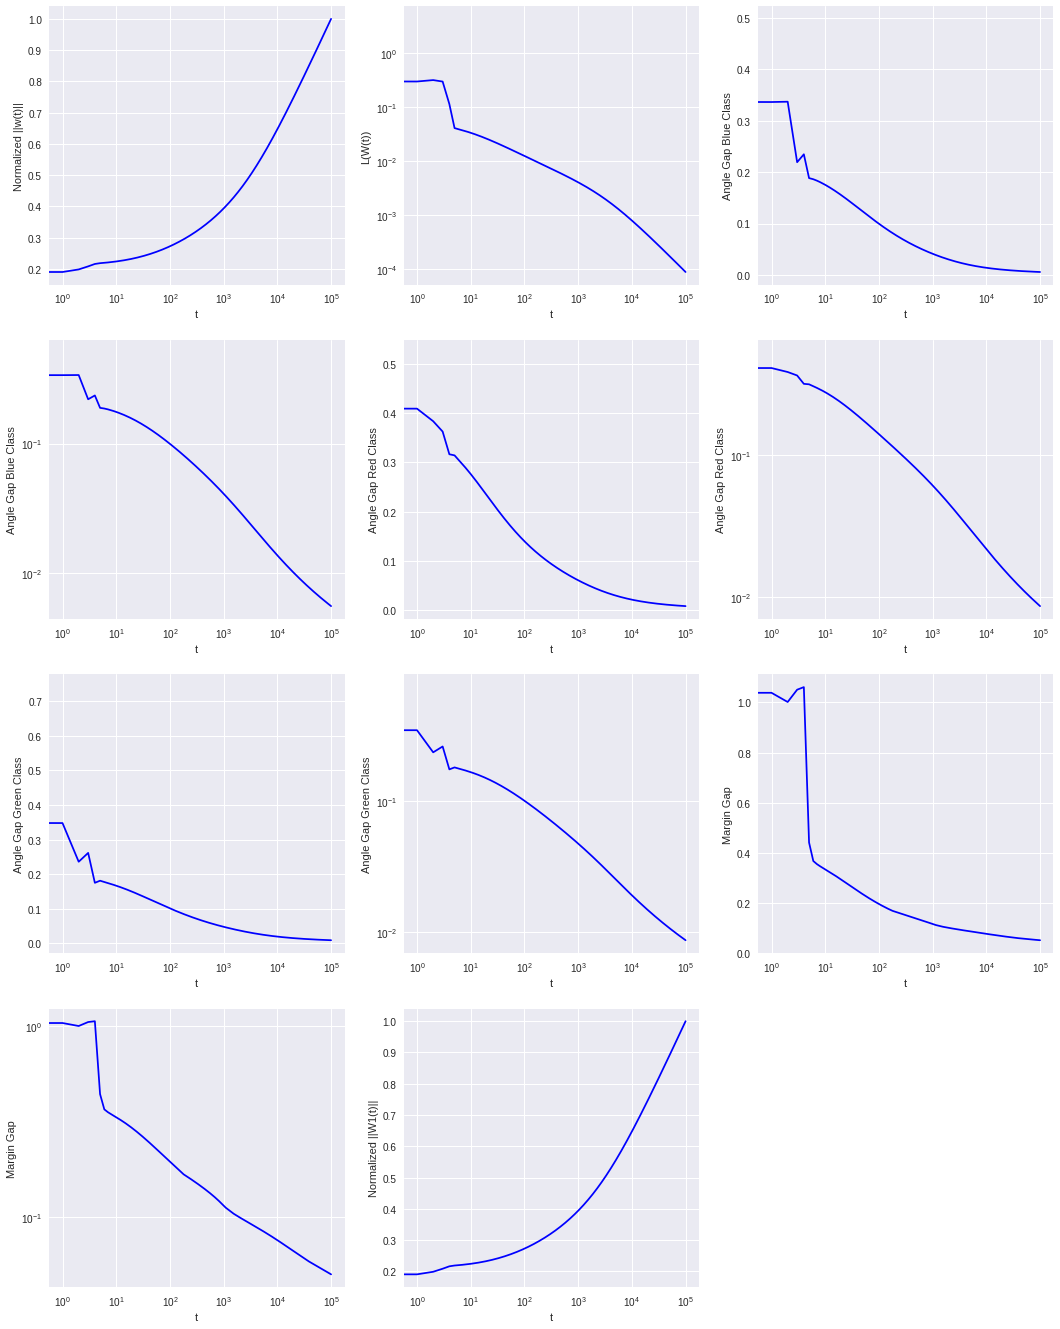

In [5]:
# Initialize the weights with a normal distribution to diversify the neurons behaviour
W1 = tf.Variable(tf.truncated_normal([3,10], stddev=0.2, dtype=tf.float64), dtype=tf.float64)

W1_norm = tf.norm(W1)
W_arr = [W1]
W_norm_arr = [W1_norm]

n_iter = 10**5
result_loss, result_norm, result_matrices, result_W_norms_arr, output_vector = TrainNN(np.transpose(data), labels, W_arr, W1, W_norm_arr, 0.1, n_iter)
DrawGraphs(n_iter, result_loss, result_norm, result_matrices, result_W_norms_arr)

 Training: 99500 out of 100000 Loss: 4.435779876641015e-06
 Graphs: 99900 out of 100000


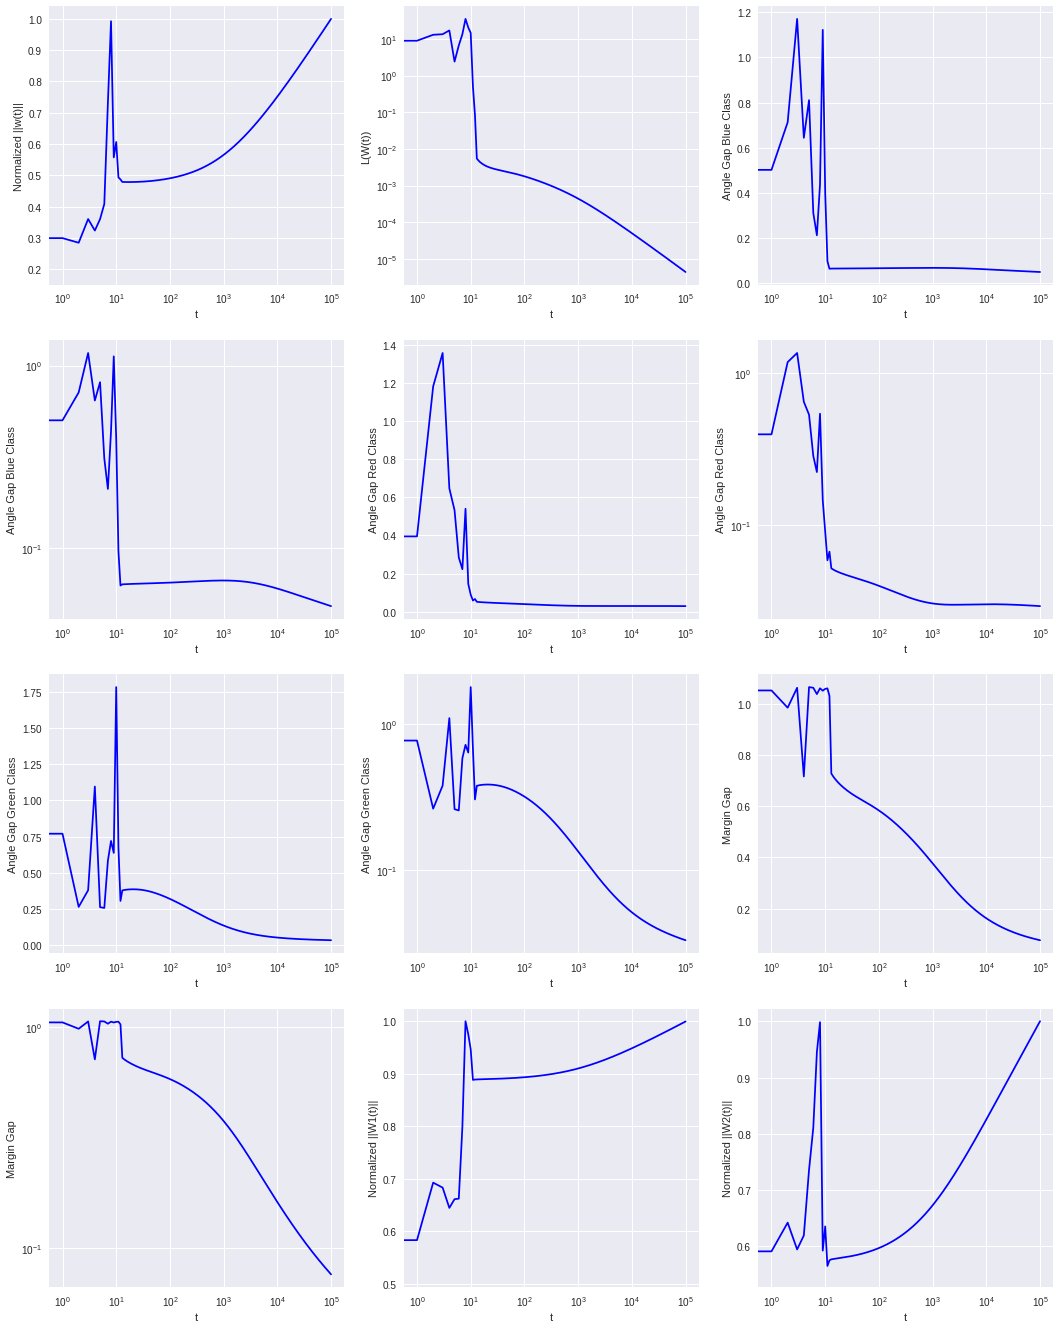

In [6]:
# Initialize the weights with a normal distribution to diversify the neurons behaviour
W1 = tf.Variable(tf.truncated_normal([4,10], stddev=0.6,  dtype=tf.float64),  dtype=tf.float64)
W2 = tf.Variable(tf.truncated_normal([4,3], stddev=0.6,  dtype=tf.float64),  dtype=tf.float64)

W = tf.matmul(W2, W1, transpose_a=True)

W1_norm = tf.norm(W1)
W2_norm = tf.norm(W2)

W_arr = [W1, W2]

W_norm_arr = [W1_norm, W2_norm]

n_iter = 10**5
result_loss, result_norm, result_matrices, result_W_norms_arr, output_vector = TrainNN(np.transpose(data), labels, W_arr, W, W_norm_arr, 0.15, n_iter)
DrawGraphs(n_iter, result_loss, result_norm, result_matrices, result_W_norms_arr)

In [7]:
# Initialize the weights with a normal distribution to diversify the neurons behaviour
W1 = tf.Variable(tf.truncated_normal([4,10], stddev=0.4,  dtype=tf.float64),  dtype=tf.float64)
W2 = tf.Variable(tf.truncated_normal([4,4], stddev=0.4,  dtype=tf.float64),  dtype=tf.float64)
W3 = tf.Variable(tf.truncated_normal([4,4], stddev=0.4,  dtype=tf.float64),  dtype=tf.float64)
W4 = tf.Variable(tf.truncated_normal([4,4], stddev=0.4,  dtype=tf.float64),  dtype=tf.float64)
W5 = tf.Variable(tf.truncated_normal([4,3], stddev=0.4,  dtype=tf.float64),  dtype=tf.float64)

W = tf.matmul(W5, tf.matmul(W4, tf.matmul(W3, tf.matmul(W2, W1, transpose_a=True), transpose_a=True), transpose_a=True), transpose_a=True)

W1_norm = tf.norm(W1)
W2_norm = tf.norm(W2)
W3_norm = tf.norm(W3)
W4_norm = tf.norm(W4)
W5_norm = tf.norm(W5)

W_arr = [W1, W2, W3, W4, W5]

W_norm_arr = [W1_norm, W2_norm, W3_norm, W4_norm, W5_norm]

n_iter = 10**5
result_loss, result_norm, result_matrices, result_W_norms_arr, output_vector = TrainNN(np.transpose(data), labels, W_arr, W, W_norm_arr, 0.15, n_iter)
DrawGraphs(n_iter, result_loss, result_norm, result_matrices, result_W_norms_arr)

 Training: 99500 out of 100000 Loss: 5.578965461433687e-07
 Graphs: 99900 out of 100000
